# Track Analysis

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.colors as colors

# FEW
from few.waveform import FastSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import get_fundamental_frequencies
from few.trajectory.flux import RunSchwarzEccFluxInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux
from few.utils.utility import get_overlap, get_mismatch, get_fundamental_frequencies, get_separatrix, get_mu_at_t
from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.trajectory.pn5 import RunKerrGenericPn5Inspiral
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform

# LISA TOOLs
from lisatools.sensitivity import get_sensitivity
from lisatools.diagnostic import (
    inner_product,
    snr,
    fisher,
    covariance,
    mismatch_criterion,
    cutler_vallisneri_bias,
    scale_snr,
)

use_gpu = False

from lisatools.sampling.likelihood import Likelihood
from lisatools.sampling.samplers.emcee import EmceeSampler
from lisatools.sampling.samplers.ptemcee import PTEmceeSampler
from lisatools.utils.utility import uniform_dist, log_uniform
from lisatools.utils.transform import TransformContainer
import warnings
import h5py


## Monochromatic signal

In [2]:

def zero_pad(data):
    """
    This function takes in a vector and zero pads it so it is a power of two.
    """
    N = len(data)
    pow_2 = np.ceil(np.log2(N))
    return np.pad(data,(0,int((2**pow_2)-N)),'constant')


# MY waveform class
class Monochromatic:

    def __init__(self, return_list=False , inspiral_kwargs={}):
        # something
        self.inspiral_kwargs = inspiral_kwargs
        self.return_list = return_list

    def __call__(
        self,
        A,
        f,
        fdot,
        fddot,
        phi,
        dt=10.0,
        T=1.0,
    ):
        YRSID_SI = 31558149.763545600
        n_pts = int(T * YRSID_SI / dt)
        T = n_pts * dt
        time_vec = np.linspace(0,T,num=n_pts)
        h = zero_pad(A*np.exp(1j* 2 * np.pi * (f + fdot * time_vec/2 + fddot/6 * time_vec * time_vec) * time_vec + phi)) 

        if self.return_list is False:
            return h

        else:
            hp = h.real
            hx = -h.imag
            return [hp, hx]

# start of the program
mon = Monochromatic(return_list=True)
mon_not_list = Monochromatic(return_list=False)

# injection array
injection_params = np.array(
    [
        np.log(1e-19), #A
        1e-3,          #f
        1e-11,         #fdot
        1e-15,         #fddot
        0              #phi
    ]
)

# which of the injection parameters you actually want to sample over
test_inds = np.array([ 1, 2, 3, 4])

# transformation of arguments from sampling basis to waveform basis
transform_fn_in = {
    "base": {0: (lambda x: np.exp(x)),},
}
# use the special transform container
transform_fn = TransformContainer(transform_fn_in)
#
check_params = transform_fn.transform_base_parameters(injection_params.copy()).T


# time stuff
dt = 10
T = 1/2
minf = 1/(T*3600*24*365)
waveform_kwargs = {"T": T, "dt": dt}

# generate waveform
h = mon(*check_params,**waveform_kwargs)

# for SNR and covariance calculation
inner_product_kwargs = dict(dt=dt, PSD="cornish_lisa_psd")

#%% another check
tot_snr_0 = snr(h,**inner_product_kwargs)


## EMRI injection

In [3]:

# INJECT EMRI
use_gpu = False
fast = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux",
    sum_kwargs=dict(pad_output=True),
    use_gpu=use_gpu,
    return_list=True,
)

# define injection parameters
M = 1.00000000e06
mu = 3.00000000e01
p0 = 1.29984395e01
e0 = 3.00000000e-01
dist = .5
Phi_phi0 = 3.2302777624860943
Phi_r0 = 4.720221760052107

# define other parameters necessary for calculation
a = 0.0
Y0 = 1.0
qS = 0.5420879369091457
phiS = 5.3576560705195275
qK = 1.7348119514252445
phiK = 3.2004167279159637
Phi_theta0 = 0.0

# fundamental frequencies
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(0.0, p0, e0, 0.0)
G = 6.6726e-11
c = 299792458
Msun = 1.9889e30
Gpc = 1.02938e17
Msun_sec = G*Msun/(c**3) 
fact = 1 /(Msun_sec * M * np.pi*2)
mode_m = 2
mode_n = 0
traj = RunSchwarzEccFluxInspiral()
ylm_gen = GetYlms(assume_positive_m=False)
t_phase_space, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0)
# get amplitudes along trajectory
amp = RomanAmplitude()
teuk_modes = amp(p, e)
# get ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, Phi_theta0, phiK).copy()[amp.inverse_lm]
# select modes
mode_selector = ModeSelector(amp.m0mask, use_gpu=False)
modeinds = [amp.l_arr, amp.m_arr, amp.n_arr]
(teuk_modes_in, ylms_in, ls, ms, ns) = mode_selector(teuk_modes, ylms, modeinds, eps=1e-2)
# number of modes
print("number of harmonics", len(ms))
theo_strong_freq = np.array([(ms[i]* OmegaPhi + ns[i]* OmegaR)
                            for i in range(len(ms))]) *fact
print(theo_strong_freq[:10])
omega_evolution = np.array([get_fundamental_frequencies(0.0, P, E, 0.0) for (P, E) in zip(p, e)])
ev_theo_freq = np.array([(ms[i]* omega_evolution[:,0] + ns[i]* omega_evolution[:,2])
                            for i in range(len(ms))]) *fact

theo_f = np.array([np.polyfit(t_phase_space, ev_theo_freq[i,:], 3)[-1] for i in range(len(ms))])
theo_fdot = np.array([np.polyfit(t_phase_space, ev_theo_freq[i,:], 3)[-2] for i in range(len(ms))])
theo_fddot = np.array([np.polyfit(t_phase_space, ev_theo_freq[i,:], 3)[-3] for i in range(len(ms))])
print('expected f',theo_f)
print('expected fdot',theo_fdot)
print('expected fddot',theo_fddot)

# injection array
emri_injection_params = np.array(
    [
        np.log(M),
        mu,
        a,  # will ignore
        p0,
        e0,
        Y0,  # will ignore
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,  # will ignore
        Phi_r0,
    ]
)

# transformation of arguments from sampling basis to waveform basis
emri_transform_fn_in = {
    "base": {0: (lambda x: np.exp(x)),},
}

# use the special transform container
emri_transform_fn = TransformContainer(emri_transform_fn_in)

# copy parameters to check values
emri_check_params = emri_injection_params.copy()

# this transforms but also gives the transpose of the input dimensions due to inner sampler needs
emri_check_params = transform_fn.transform_base_parameters(emri_check_params).T

# INJECTION kwargs
emri_waveform_kwargs = {"T": T, "dt": dt, "eps": 1e-2}

check_sig = fast(*emri_check_params, **emri_waveform_kwargs)


print('SNR emri', snr(check_sig,**inner_product_kwargs))


number of harmonics 5
[0.00078023 0.00123137 0.00168252 0.00213366 0.00258481]
expected f [0.00078018 0.00123131 0.00168245 0.00213359 0.00258472]
expected fdot [5.36000296e-12 7.44865359e-12 9.53730422e-12 1.16259548e-11
 1.37146055e-11]
expected fddot [2.89366675e-20 4.05077626e-20 5.20788578e-20 6.36499529e-20
 7.52210481e-20]
SNR emri 25.095064294271417


## Likelihood

In [4]:
# full dimensionality of inputs to waveform model
ndim_full = 5  

# ndim for sampler
ndim = len(test_inds)

# need to get values to fill arrays for quantities that we are not sampling
fill_inds = np.delete(np.arange(ndim_full), test_inds)
fill_values = injection_params[fill_inds]

# to store in sampler file, get injection points we are sampling
injection_test_points = injection_params[test_inds]

nchannels = 2
# define sampling quantities
nwalkers = len(theo_f)  # per temperature
ntemps = 1

# define
like = Likelihood(
    mon, nchannels, dt=dt, parameter_transforms=transform_fn, use_gpu=use_gpu,
)

# inject
like.inject_signal(
    # in this way I provide the data stream
    data_stream=[zero_pad(check_sig[0]), zero_pad(check_sig[1])],
    #params=injection_params.copy(),
    #waveform_kwargs=waveform_kwargs,
    noise_fn=get_sensitivity,
    noise_kwargs=dict(sens_fn="cornish_lisa_psd"),
    add_noise=True,
)

# define priors, it really can only do uniform cube at the moment
priors = [
    #uniform_dist(np.log(1e-25), np.log(1e-15)), # A
    log_uniform(5e-5, 1e-2), #f
    log_uniform(5e-15, 5e-10), #fdot
    log_uniform(5e-25, 0.5e-18), #fddot
    uniform_dist(0, 2*np.pi), # phi
]

# not all walkers can fit in memory. subset says how many to do at one time
subset = 1

# set kwargs for the templates
waveform_kwargs_templates = waveform_kwargs.copy()

# random starts
np.random.seed(3000)
start_points = np.zeros((nwalkers * ntemps, ndim))

# starting point
for i in range(ndim):
    start_points[:, i] = priors[i].rvs(nwalkers * ntemps) 

start_points[:,0] = theo_f
start_points[:,1] = theo_fdot
start_points[:,2] = theo_fddot
start_points[:,3] = priors[3].rvs(nwalkers * ntemps) 

# check the starting points
start_test = np.zeros((nwalkers * ntemps, ndim_full))

# need to set sampling and non-sampling quantities
start_test[:, test_inds] = start_points
start_test[:, fill_inds] = fill_values

split_inds = np.split(np.arange(len(start_test)), int(len(start_test) / subset))

start_ll = np.asarray(
    [
        like.get_ll(start_test[split], waveform_kwargs=waveform_kwargs)
        for split in split_inds
    ]
)

In [5]:
start_ll

array([[1.99129397e+09],
       [6.15057989e+09],
       [1.32335305e+09],
       [8.88781097e+09],
       [4.99178936e+12]])

# Analysis MCMC

In [6]:
# import data
dset = h5py.File('test_mono_no_noise2.h5')
data = dset['mcmc']
chain = dset['mcmc/chain']
data.keys()

<KeysViewHDF5 ['accepted', 'blobs', 'chain', 'log_prob']>

walker  0  log_prob  -956.7452574555291
walker  1  log_prob  -957.5347446824825
walker  2  log_prob  -955.894280181253
walker  3  log_prob  -955.671211639664
walker  4  log_prob  -955.1566679177935
walker  5  log_prob  -956.2655742698547
walker  6  log_prob  -956.0278986785577
walker  7  log_prob  -956.2188240145605


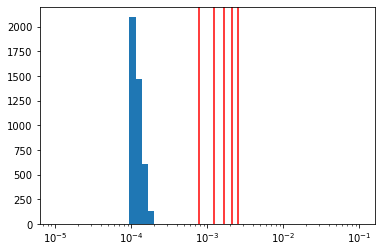

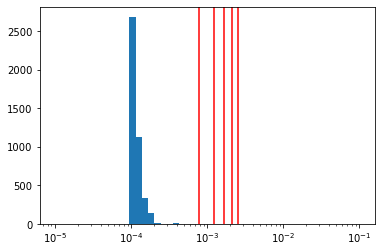

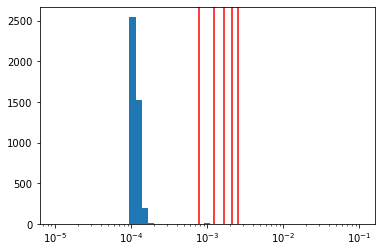

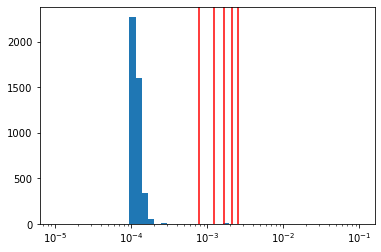

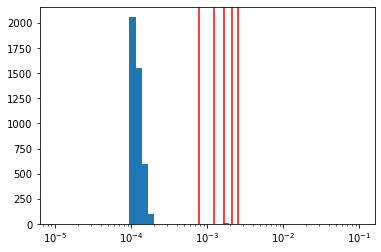

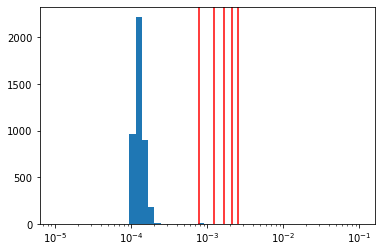

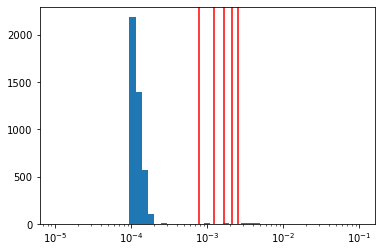

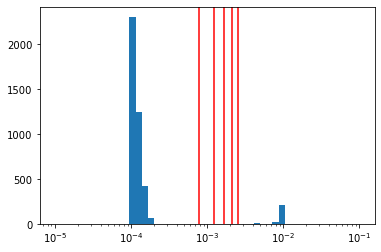

In [10]:
# analyse chain
walker_i = 0
variable_i = 0

for walker_i in range(8):

    samp = chain[:,walker_i,variable_i]

    # fiure
    plt.figure()
    #plt.semilogy(samp)
    for i in range(len(theo_f)):
        plt.axvline(theo_f[i],color='r')
    plt.hist(samp, bins=np.logspace(-5,-1))
    plt.xscale('log')
    
    print('walker ',walker_i,' log_prob ', dset['mcmc/log_prob'][300:1500,walker_i][-1])
    


In [ ]:
f_spec, t_spec, Sxx_spec = signal.spectrogram(check_sig[0] , 1/dt,  window=('tukey', 1), 
                            nperseg=50000, 
                            noverlap=40000, 
                            nfft=None, detrend='constant', 
                            return_onesided=True, scaling='density',axis=- 1, mode='psd')


plt.figure(figsize=(10,10))
plt.pcolormesh(t_spec/60/60/24, f_spec, Sxx_spec, norm=colors.LogNorm(vmin=1e-48, vmax=1e-38), alpha = 1)

plt.ylabel('Frequency [Hz]',fontsize = 20)
plt.xlabel('Time [days]',fontsize = 20)
plt.title(r'Spectrogram of $\eta =$ '+str(mu/M)+ r', $e_0 =$ '+str(e0)+ r', $p_0 = $ '+str(p0) ,fontsize = 20)
plt.colorbar()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim([1e-5,1e-2])
plt.yscale('log')
#plt.xlim([0,30])


for i in range(5):
    plt.plot(t_phase_space/60/60/24, ev_theo_freq[i,:], linestyle='dotted', color='r')